Table of Contents
* [1 Introduction](#introduction)
* [2 Preprocessing the data](#_2)
    * [2.1 Cleaning the data](#_21)
    * [2.2 Encoding the data](#_22)
* [3 Exploring the data](#_3)
    * [3.1 Graphical summaries](#_31)
    * [3.2 Numerical summaries](#_32)
* [4 Regression models](#_4)
    * [4.1 Train models](#_41)
    * [4.2 Cross-validation](#_42)
    * [4.3 Tuning hyperparameters](#_43)
    * [4.4 Model evaluation on testing data](#_44)
    * [4.5 Checking assumptions of linear regression](#_45)
* [5 Discussion](#_5)
   

# 1 Introduction <a id="introduction"></a>

In this notebook, we will try to predict the price of a laptop using different specifications about the laptop.

In [1]:
# Import the data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import re
fname = "/kaggle/input/laptop-price-prediction-using-specifications/LaptopPricePrediction.csv"
df_orig = pd.read_csv(fname)

# 2 Preprocessing the data <a id="_2"></a>

## 2.1 Cleaning the data <a id="_21"></a>

In [2]:
# Clean it
df = df_orig.copy()

# Drop unamed col
df = df.drop(list(df.filter(regex="Unnamed.*")),axis=1)
#print(df.dtypes)

# Convert price to a number
df.Price = df.Price.str.replace(r'[^0-9]','',regex=True).astype('int')

# Convert storage to number
# Remove the secondary storage
df.Storage = df.Storage.str.split('|').str[0]
df.Storage = np.where(df.Storage.str.split(' ').str[0] == "M.2","256 GB SSD",df.Storage)
df['Storage_GB'] = np.where(
    df.Storage.str.split(' ').str[1] == "TB",
    pd.to_numeric(df.Storage.str.split(' ').str[0],errors="coerce")*1024,
    pd.to_numeric(df.Storage.str.split(' ').str[0],errors="coerce")
)
str_med = df.Storage_GB.mean()
df.Storage_GB = df.Storage_GB.fillna(value=str_med)
df['Storage_Type'] = np.where(df.Storage.str.contains('SSD'),"SSD","HDD")
df = df.drop('Storage',axis=1)

# Convert display size to number
df.Display = pd.to_numeric(
    df.Display.str.split(' ').str[0].replace(r'[^0-9.]','',regex=True),
    errors="coerce"
)
# Fix the inches, convert to cm
df.loc[df.Display == 15.6,"Display"] = 39.624 # 15.6 * 2.54
# Fill NAs with mean
disp_med = df.Display.mean()
df.Display = df.Display.fillna(value=disp_med)

# Convert RAM to number
def ram_type(x):
    x = str(x)
    if "DDR3" in x:
        return "DDR3"
    elif "DDR4" in x:
        return "DDR4"
    else:
        return "DDR4"

df["RAM_Type"] = df.RAM.apply(ram_type)
df.RAM = pd.to_numeric(df.RAM.str.split(' ').str[0],errors="coerce")
# Fix MB values
df.RAM = df.RAM.apply(lambda x: x if x<100 else x/1024)
ram_med = df.RAM.mean()
df.RAM = df.RAM.fillna(value=ram_med)
#print(df.RAM.describe())

# Convert Brand Name and Model Name
df['Brand_Name'] = df.Name.str.split(' ').str[0]
#df['Model_Name'] = df.Name.str.split(' ').str[0:2].str.join('_')
df = df.drop('Name',axis=1)

# Convert CPU name
def cpu_conv(x):
    x = str(x)
    #print("***",x)
    cpu_name = ""
    cpu_gen = ""
    if re.search('[0-9]{1,2}[a-z]{2} Gen',x):
        cpu_gen = re.search('([0-9]{1,2}[a-z]{2} Gen)',x).group(1)
    if re.search('i[0-9]',x):
        cpu_name = re.search('(i[0-9])',x).group(1)
    elif re.search('Ryzen [0-9]',x):
        cpu_name = re.search('(Ryzen [0-9])',x).group(1)
    elif re.search('A[0-9]',x):
        cpu_name = re.search('(A[0-9])',x).group(1)
    elif re.search('AMD \w+ ',x):
        cpu_name = re.search('(AMD \w+) ',x).group(1)
    elif re.search("Intel \w+ ",x):
        cpu_name = re.search('(Intel \w+) ',x).group(1)
    else:
        cpu_name = "Unknown"
    cpu = f"{cpu_name.replace(' ','_')}_{cpu_gen.replace(' ','_')}"
    #cpu = cpu_name.replace(' ','_')
    #print(cpu)
    return cpu
def cpu_brand(x):
    x = str(x)
    brand = "Other"
    if "Core i" in x:
        brand = "Intel"
    elif "Intel" in x:
        brand = "Intel"
    elif "AMD" in x:
        brand = "AMD"
    return brand
df["CPU_Brand"] = df.Processor.apply(cpu_brand)
df.Processor = df.Processor.apply(cpu_conv)

# Convert OS name
os_dict = {
    "64 bit Windows 10 Operating System": "win10",
    "Windows 10 Operating System": "win10",
    "Mac OS Operating System": "mac",
    "Pre-installed Genuine Windows 10 Operating System (Includes Built-in Security, Free Automated Updates, Latest Features)":
        "win10_sec",
    "DOS Operating System":"dos",
    "64 bit Chrome Operating System": "chrome"
}
df["Operating System"] = df["Operating System"].apply(lambda x: os_dict.get(x, np.nan))

# Convert warranty
def warr_conv(x):
    x = str(x).lower()
    time = 0
    if "ne-year" in x:
        time = 12
    elif "year" in x:
        time = int(x.split(' ')[0])*12
    elif "month" in x:
        time = int(x.split(' ')[0])
    return time
df.Warranty = df.Warranty.apply(warr_conv)

print(df.head())

        Processor  RAM Operating System  Display  Warranty  Price  rating  \
0     i5_10th_Gen  8.0            win10    39.62        12  43990     3.9   
1     i3_11th_Gen  8.0            win10    35.56        12  43990     4.2   
2  Intel_Pentium_  8.0            win10    35.56        12  31490     4.6   
3     i3_11th_Gen  8.0            win10    35.56        12  40990     4.1   
4     AMD_Athlon_  4.0            win10    39.62        12  27490     4.1   

   Storage_GB Storage_Type RAM_Type Brand_Name CPU_Brand  
0        1024          HDD     DDR4     Lenovo     Intel  
1         256          SSD     DDR4     Lenovo     Intel  
2         256          SSD     DDR4         HP     Intel  
3         256          SSD     DDR4         HP     Intel  
4        1024          HDD     DDR4         HP       AMD  


## 2.2 Encoding the data <a id="_22"></a>
We are encoding most categorical variables using Target Encoding because many variables have high cardinality (many different categories). For binary variables we can just one-hot encode.

In [3]:
# encode the data
# One-hot encode low-cardinality data
if 'Storage_Type' in df and 'CPU_Brand' in df and 'RAM_Type' in df:
    one_hot = pd.get_dummies(df['Storage_Type'],drop_first=True)
    df = df.drop('Storage_Type',axis=1).join(one_hot)

    one_hot = pd.get_dummies(df['CPU_Brand'],drop_first=True)
    df = df.drop('CPU_Brand',axis=1).join(one_hot)
    
    one_hot = pd.get_dummies(df['RAM_Type'],drop_first=True)
    df = df.drop('RAM_Type',axis=1).join(one_hot)

# Target encode other data
cols = [col for col in df.columns if df[col].dtype == "O"]
for col in cols:
    mean_labels = df.groupby([col]).Price.mean()
    #print(mean_labels.to_dict())
    df[col] = df[col].map(mean_labels.to_dict())
#print(df)

# 3 Exploring the data <a id="_3"></a>

## 3.1 Graphical summaries <a id="_31"></a>

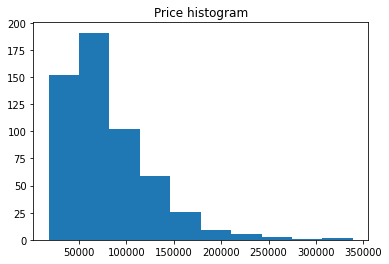

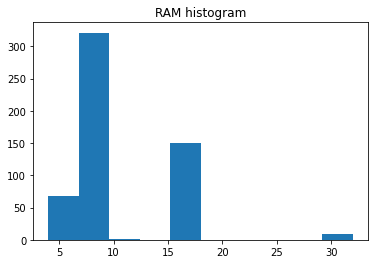

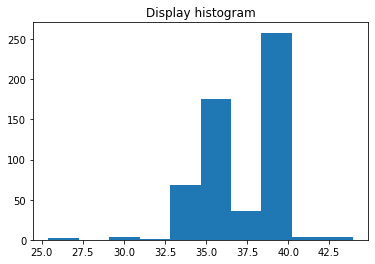

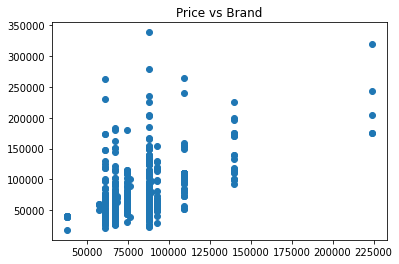

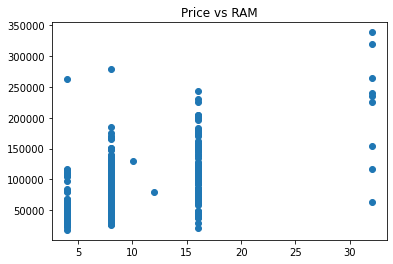

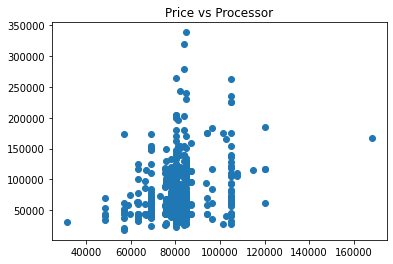

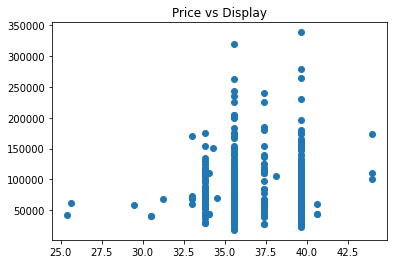

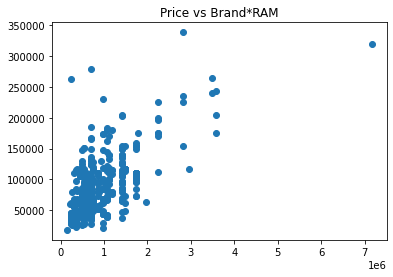

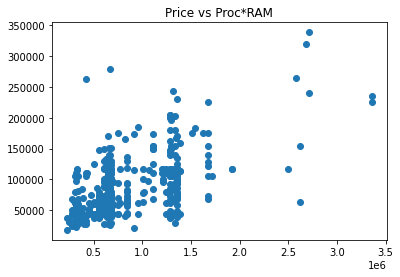

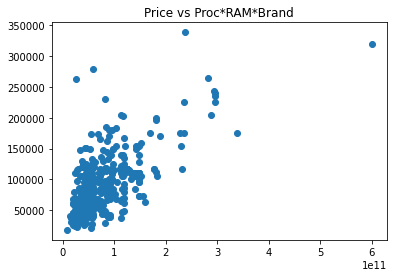

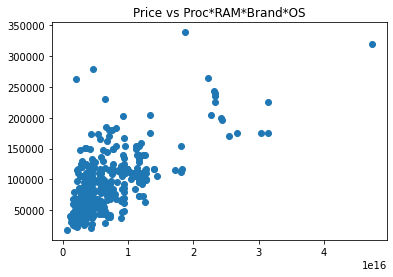

In [4]:
from matplotlib import pyplot as plt
plt.hist(df.Price)
plt.title("Price histogram")
plt.show()
plt.hist(df.RAM)
plt.title("RAM histogram")
plt.show()
plt.hist(df.Display)
plt.title("Display histogram")
plt.show()
plt.scatter(df.Brand_Name, df.Price)
plt.title("Price vs Brand")
plt.show()
plt.scatter(df.RAM, df.Price)
plt.title("Price vs RAM")
plt.show()
plt.scatter(df.Processor, df.Price)
plt.title("Price vs Processor")
plt.show()
plt.scatter(df.Display, df.Price)
plt.title("Price vs Display")
plt.show()
plt.scatter(df.Brand_Name*df.RAM,df.Price)
plt.title("Price vs Brand*RAM")
plt.show()
plt.scatter(df.Processor*df.RAM, df.Price)
plt.title("Price vs Proc*RAM")
plt.show()
plt.scatter(df.Processor*df.RAM*df.Brand_Name,df.Price)
plt.title("Price vs Proc*RAM*Brand")
plt.show()
plt.scatter(df.Processor*df.RAM*df.Brand_Name*df["Operating System"],df.Price)
plt.title("Price vs Proc*RAM*Brand*OS")
plt.show()

The data seems to have high variance (highly spread out), so it may be difficult to predict prices from these features. The data points seem spread out from a best fit line (high residual values). The interaction between processor, brand, and RAM seems to be a good predictor, as well as the brand and RAM alone.

## 3.2 Numerical summaries <a id="_32"></a>

In [5]:
print(f"Summary of Price values: {df.Price.describe()}")
df["Proc_Brand_RAM"] = (df.Processor*df.RAM*df.Brand_Name)
df = df.drop("Unnamed: 0",axis=1,errors="ignore")
print("Linear correlations:")
all_corr = df.corr(method="pearson")
corrs = (all_corr.filter(['Price'])
      .query('abs(Price) > 0')
      .sort_values(by='Price',ascending=False,key=abs,axis=0)
      .assign(r2 = lambda x: x.Price**2)
)
print(corrs)
# Find RMSE from R^2
# R^2 = 1 - SSR/SST 
# R^2 - 1 = -SSR/SST
# -R^2 + 1
# 1 - R^2 = SSR/SST
# SST*(1-R^2) = SSR
# Use definition of Mean Squared Error (MSE)
# MSE = (1/n)*SSR
# RMSE = sqrt((1/n)*SSR)
# RMSE = sqrt((1/n)*SST*(1-R^2))
n = df.Price.size
p = len(df.columns) - 1
corr_matrix = all_corr.drop(["Price"],axis=1).drop(["Price"],axis=0).to_numpy()
price_corr = all_corr.filter(['Price']).query('Price != 1').to_numpy()
total_r2 = (price_corr.transpose() @ np.linalg.inv(corr_matrix) @ price_corr).item()
#total_r2 = 1 - ((1 - total_r2)*(n-1)/(n-p-1))
sst = sum(np.square(df.Price - df.Price.mean()))
rmse = np.sqrt((1/n)*sst*(1-total_r2))
print(f"Ideal R^2: {total_r2}")
print(f"Ideal RMSE: {rmse}")

Summary of Price values: count       550.000000
mean      81364.138182
std       45119.284969
min       17990.000000
25%       46990.000000
50%       65990.000000
75%      107990.000000
max      338990.000000
Name: Price, dtype: float64
Linear correlations:
                     Price        r2
Price             1.000000  1.000000
Proc_Brand_RAM    0.701526  0.492139
RAM               0.573540  0.328948
Brand_Name        0.540727  0.292386
Processor         0.248973  0.061987
Operating System  0.241420  0.058283
Intel            -0.055424  0.003072
SSD               0.053350  0.002846
DDR4             -0.041001  0.001681
Display          -0.032377  0.001048
Warranty          0.021708  0.000471
Storage_GB       -0.017648  0.000311
rating            0.009237  0.000085
Ideal R^2: 0.5213529173269126
Ideal RMSE: 31187.082140731505


The R^2 value using the Pearson (linear) correlation coefficient for the data is 0.52. This means the predictors explain 52% of the variance of the target (price). Root Mean Squared Error can be calculated from this R^2 value, and we get a value of about 31,187. This is the goal R^2 and RMSE value for ML models. The R^2 value of 0.52 corresponds to a R (correlation coefficient) value of about 0.72, which is a moderate linear relationship. Other correlation coefficients, such as Spearman and Kendall (these assess non-linear correlations, usually with ranked data) showed lower values.

The strongest correlations with Price besides Price itself are the interaction between Processor, Brand, and RAM, then RAM, Brand Name, the Operating System, and the Processor individually. The RAM for example, explains 32.9% of the variance of the computer price, and the brand name explains 29.2% of the variance.

Knowing these features, we can create models to predict the price of a laptop based on these features.

# 4 Regression models <a id="_4"></a>

## 4.1 Train models <a id="_41"></a>

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
y = df.Price
X = df.drop('Price',axis=1,errors="ignore")#.filter(["Brand","RAM","Processor"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear model
lm = LinearRegression()
lm.fit(X_train, y_train)
# Random forest
rf_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5}
rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features="sqrt",max_depth=5, random_state=1)
rf.fit(X_train, y_train)
# Gradient Boosting
gb_params = {'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 15}
gb = GradientBoostingRegressor(n_estimators=200, min_samples_split=100, min_samples_leaf=10, max_features="sqrt",max_depth=15, random_state=1)
gb.fit(X_train, y_train)
# Extra Trees
et_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5}
et = ExtraTreesRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features="sqrt",max_depth=5, random_state=1)
et.fit(X_train, y_train)
# Voting regressor
#vr = VotingRegressor([('lm',lm),('rf',rf),('gb',gb),('et',et)])
vr = VotingRegressor([('lm',lm),('rf',rf)])
vr.fit(X_train, y_train)

models = [lm, rf, gb, et, vr]

## 4.2 Cross-validation <a id="_42"></a>

In [7]:
for model in models:
    xval = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    xvm = xval.mean()
    xvs = xval.std()
    mname = str(model).split('(')[0]
    print(f"{mname}: Mean={xvm:.2f}, Stdev={xvs:.2f}, 95% CI=({xvm-2*xvs:.2f},{xvm+2*xvs:.2f})")

LinearRegression: Mean=0.46, Stdev=0.13, 95% CI=(0.20,0.73)
RandomForestRegressor: Mean=0.40, Stdev=0.11, 95% CI=(0.18,0.63)
GradientBoostingRegressor: Mean=0.30, Stdev=0.17, 95% CI=(-0.05,0.65)
ExtraTreesRegressor: Mean=0.36, Stdev=0.09, 95% CI=(0.17,0.55)
VotingRegressor: Mean=0.45, Stdev=0.11, 95% CI=(0.23,0.68)


The cross-validation shows that the best performing model is the Linear Regression, with the voting regressor in second place, with slightly lower variance than the Linear Regression.

## 4.3 Tuning hyperparameters <a id="_43"></a>

In [8]:
rf_tune = False
gb_tune = False
et_tune = False
for model in models:
    mname = str(model).split('(')[0]
    #print(f"{mname}: {model.get_params()}\n")
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
# bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rg2 = random_grid.copy()
#rg2['gamma']
if rf_tune:
    rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
    rs.fit(X_train, y_train)
    print(rs.best_params_)
    print(rs.best_score_)
if gb_tune:
    rs = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
    rs.fit(X_train, y_train)
    print(rs.best_params_)
    print(rs.best_score_)
if et_tune:
    rs =  RandomizedSearchCV(estimator = et, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
    rs.fit(X_train, y_train)
    print(rs.best_params_)
    print(rs.best_score_)

## 4.4 Model evalulation on testing data <a id="_44"></a>

In [9]:
for model in models:
    mname = str(model).split('(')[0]
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test,y_pred,squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    y_m = y.mean()
    print(f"{mname}:")
    print("RMSE: " + str(rmse))
    print("RMSE ($): " + str(rmse*0.013))
    print("RMSE (%): " + str(rmse/y_m*100))
    print("MAE: " + str(mae))
    print("MAE ($): " + str(mae*0.013))
    print("MAE (%): " + str(mae/y_m*100))
    print("R^2 (training): " + str(r2_score(y_train,model.predict(X_train))))
    print("R^2: " + str(r2_score(y_test,y_pred)))
    print("\n")

LinearRegression:
RMSE: 30597.30285317604
RMSE ($): 397.7649370912885
RMSE (%): 37.60539168349894
MAE: 21208.572368822537
MAE ($): 275.711440794693
MAE (%): 26.066241027993648
R^2 (training): 0.5126316008150873
R^2: 0.5212740736804882


RandomForestRegressor:
RMSE: 31466.31444193258
RMSE ($): 409.0620877451235
RMSE (%): 38.67344403208355
MAE: 21505.31758292928
MAE ($): 279.56912857808067
MAE (%): 26.430953566881026
R^2 (training): 0.5916270316915389
R^2: 0.4936947691650986


GradientBoostingRegressor:
RMSE: 33310.28904823856
RMSE ($): 433.0337576271013
RMSE (%): 40.9397675592687
MAE: 23071.515842136258
MAE ($): 299.9297059477713
MAE (%): 28.355878102684645
R^2 (training): 0.7601466326667662
R^2: 0.4326155092452474


ExtraTreesRegressor:
RMSE: 31787.65855015161
RMSE ($): 413.2395611519709
RMSE (%): 39.06838966218529
MAE: 22898.181127675416
MAE ($): 297.6763546597804
MAE (%): 28.14284233737794
R^2 (training): 0.48807592363731855
R^2: 0.48330086260578


VotingRegressor:
RMSE: 30699.769089

Final evaluation on the training data shows that the Linear Regression is the most accurate model, with an R^2 of 0.52, the same as the 0.52 based on the original linear correlation, and with a RMSE of 30,597, which is 38% of the mean price.

## 4.5 Checking assumptions of linear regression <a id="_45"></a>

Linear regression generally assumes that the residuals are independent and follow a normal distribution and constant variance over all independent variable values.

Residuals likely close to normal
Mu: -810.39, Sigma: 30586.57, skew: 1.81, ex. kurt: 6.9


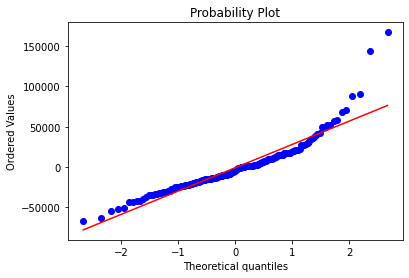

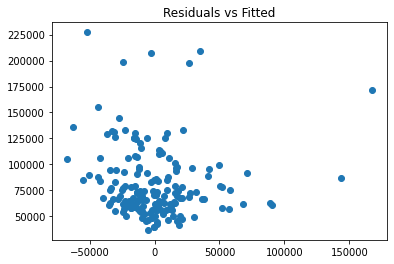

In [10]:
import scipy as sc
import seaborn as sb
# Test normality of residuals
y_pred = lm.predict(X_test)
res = (y_test - y_pred)
#res = (y_train - lm.predict(X_train))
mu = np.mean(res)
s = np.std(res)
skew = sc.stats.skew(res)
kurt = sc.stats.kurtosis(res,fisher=True)
if abs(kurt) > 7 or abs(skew) > 2:
    print("Residuals likely non-normal")
else:
    print("Residuals likely close to normal")
print(f"Mu: {round(mu,2)}, Sigma: {round(s,2)}, skew: {round(skew,2)}, ex. kurt: {round(kurt,2)}")
sc.stats.probplot(res,plot=plt);
plt.show()
plt.scatter(res, y_pred)
plt.title("Residuals vs Fitted")
plt.show()
#sb.kdeplot(data=res,bw_adjust=0.2)

The QQ plot, as well as skewness and kurtosis values, show that the residuals are close to being normally distributed. There is some pattern in the residuals vs fitted plot, meaning that the errors are not independent, and do not have a constant variance. This means that a linear model probably isn't the best fit for the data. However, the model still has good predictive performance compared with the other models, so there is not reason to stop using it.

# 5 Discussion <a id="_5"></a>

The best price predicting model (Linear Regression) on the testing data got an R^2 of about 0.521 on the testing data, with a Root Mean Square Error of 30,597, or about a 38% error on average. The second best model, the Voting Regressor (based on Linear Regression and Random Forest), had an R^2 of 0.518, and about the same performance as Linear Regression on cross-validation (mean R^2 of 0.45 vs 0.46), and with a slightly lower standard deviation of 0.11 compared to the 0.13 for Linear Regression.

The features in the data with the strongest linear correlations with Price are RAM (r=0.57), Brand Name (r=0.54), Operating System (r=0.25), and Processor (r=0.24). RAM and Brand Name are by far the strongest of the correlations with price. RAM has a positive correlation with price. Warranty (r=0.02), the presence of an SSD (r=0.05), and rating (r=0.01) have a small positive correlation with price. Having an Intel Processor (r=-0.05), DDR4 memory (r=-0.04), more storage (r=-0.02), and a larger display (r=-0.03) have a negative correlation with price.